<a href="https://colab.research.google.com/github/pachterlab/GVFP_2021/blob/dev/figure_3_notebook_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Interpretable and tractable models of transcriptional noise for the rational design of single-molecule quantification experiments"
## by Gennady Gorin<sup>*</sup>, John Vastola<sup>*</sup>, Meichen Fang, and Lior Pachter
### <sup>*</sup> These authors contributed equally to this work.
# Companion notebook for Figure 3 

This notebook is self-contained, and generates the panels used in Figure 3 (albeit mostly without axis labels). There are five panels:

**a**. Log Bayes factors across space of qualitative regimes

**b**. Slice of a. to show distinguishability as a function of the gain ratio

**c**. Distinguishability of two models versus trivial models as function of gain ratio

**d**. Example parameter set for which $\Gamma$-OU and CIR are very different

**e**. Bayesian parameter inference

The sections of this notebook, apart from the first (which contains relevant functions), correspond to the above panels.

In [ ]:
# Scientific computing imports
import numpy as np
from numpy.fft import irfftn
from numpy.random import choice
from scipy.stats import rv_discrete, poisson, nbinom, gaussian_kde
import matplotlib.pyplot as plt

# PyMC3-related imports
import pymc3 as pm
import theano.tensor as tt

# Plotting
import matplotlib.pyplot as plt
import arviz as az
import matplotlib as mpl

# Timer
import time as ti

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
!mkdir -p results
!mkdir -p bayes_runs

------------------------------------------------

## Functions

### General-purpose functions

In [ ]:
# Utility function that converts between (x, y) qualitative regime coordinates to original parameters.
def convert_xy_to_params(x, y, beta, gamma, K_avg):
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    return a, kappa, theta


# Sample from flattened 2D probability distribution p. 
# mx = [mx0, mx1] is the shape of the 2D domain we're sampling.
def sample_from_p(mx, num_data_points, p_flat):
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M


# Get maximum of a 2D array
def get_2D_max(array):
    return np.unravel_index(array.argmax(), array.shape)


# Get KDE for smooth-looking heatmaps.
def get_2D_KDE(x_stats, y_stats, x_min=0, x_max=1, y_min=0, y_max=1):
    num_pts = 100                          # hyperparameter
    x_arg = np.linspace(x_min, x_max, num_pts)
    y_arg = np.linspace(y_min, y_max, num_pts)

    X_arg, Y_arg = np.meshgrid(x_arg, y_arg, indexing='ij')      # grid of points      X0, X1

 
    positions = np.vstack([X_arg.ravel(), Y_arg.ravel()])
    kernel = gaussian_kde([x_stats, y_stats])
    KDE = np.reshape(kernel(positions).T, X_arg.shape)
    return KDE, x_arg, y_arg
    

### Trivial model (constitutive/Poisson and mixture/NB) likelihood functions

In [ ]:
# Constitutive model likelihood function.
def get_Poiss_2sp(mx, params):
    beta, gamma, a, kappa, theta = params 
    K_avg = (a*theta)/kappa
    mu_N, mu_M = K_avg/beta, K_avg/gamma
    
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')
    
    return poisson.pmf(X_N, mu_N)*poisson.pmf(X_M, mu_M)


# Mixture model likelihood function.
def get_NB_2sp(mx, params):
    beta, gamma, a, kappa, theta = params 
    
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = np.exp(- (a/kappa)*np.log(1 - theta*(g[0]/beta + g[1]/gamma)))
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss

### $\Gamma$-OU likelihood functions

In [ ]:
# Get 2 species GOU generating function using ODE method
def get_gf_GOU_2sp_ODE(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 0.25, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))
    
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))
    q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1
    

    integrand = q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    return gf


# Get Pss for 2 species GOU model via ODE method
def get_GOU_2sp(mx, params):
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_GOU_2sp_ODE(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# Log likelihood of GOU model given data. Uses (x,y) as input instead of (kappa, theta).
def ll_GOU(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_GOU_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[tuple(data)])
    return result


# Combines the above functions into one to reduce overhead associated with Python function calls.
# Helpful when doing expensive posterior sampling (since many likelihood function calls are required).
def ll_GOU2(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    beta_0 = beta
    beta_1 = gamma
    
    c0 = (g[0]) + (beta_0/(beta_1 - beta_0))*(g[1])       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g[1])   
    
    min_fudge, max_fudge = 0.5, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
    
    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))
    
    q = np.zeros((c0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))
    q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1

    integrand = q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize

    lp = np.log(Pss)
    result = np.sum(lp[tuple(data)])
    return result

### CIR likelihood functions

In [ ]:
# ODE for 2 species CIR model
def f_2sp(q, t, c0, c1, params):
    beta_0, beta_1, a, kappa, theta = params
    result = - kappa*q + theta*q*q + kappa*( c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t)  ) 
    return result


# Vectorized RK4 implementation for 2 species CIR model
def RK4_2sp(q, f, t, c0, c1, step_size, param):
    j1 = f(q, t, c0, c1, param)
    j2 = f(q + (step_size/2)*j1, t + (step_size/2), c0, c1, param)   
    j3 = f(q + (step_size/2)*j2, t + (step_size/2), c0, c1, param)   
    j4 = f(q + (step_size)*j3, t + (step_size), c0, c1, param)  
    
    q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
    return q_new


# Get 2 species CIR generating function using ODE method
def get_gf_CIR_2sp(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 0.25, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
     
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    
    # Solve ODE using RK4 method 
    for i in range(0, num_tsteps):
        t = i*dt
        q[:,i+1] = RK4_2sp(q[:,i], f_2sp, t, c0, c1, dt, params)
        
    integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp((a*theta/kappa)*integral)               # get generating function
    return gf


# Get Pss for 2 species CIR model via ODE method
def get_CIR_2sp(mx, params):
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_CIR_2sp(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# Log likelihood of CIR model given data. Uses (x,y) as input instead of (kappa, theta).
def ll_CIR(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_CIR_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result

### Bayes factor functions

In [ ]:
# Generates synthetic data (either CIR or GOU) and computes log Bayes factor (e.g. P(CIR)/P(GOU))).
# Does this averaged over many trials (num_trials).
# Does this assuming different numbers of data points (e.g. num_data_points = [100, 200, 1000]). 
def log_bayes_factor_avg(model, num_data_points, num_trials, mx, params):
    
    # Initialize log BF arrays 
    num_kinds = len(num_data_points) 
    log_bf_joint = np.zeros((num_kinds, num_trials))
    log_bf_nascent = np.zeros((num_kinds, num_trials))
    log_bf_mature = np.zeros((num_kinds, num_trials))
    
    # Get Pss for each model given this parameter set
    if model=='CIR':
        pss = get_CIR_2sp(mx, params)
        pss_other = get_GOU_2sp(mx, params)
    elif model=='GOU':
        pss = get_GOU_2sp(mx, params)
        pss_other = get_CIR_2sp(mx, params)
    p_flat = pss.flatten()
    
    
    

    # Log-likelihood functions
    lp = np.log10(pss)    # shape: x_N_domain by x_M_domain
    lp_nascent = np.log10(np.sum(pss, axis=1))
    lp_mature = np.log10(np.sum(pss, axis=0))

    lp_other = np.log10(pss_other)
    lp_other_nascent = np.log10(np.sum(pss_other, axis=1))
    lp_other_mature = np.log10(np.sum(pss_other, axis=0))
    
    

    
    # Get fake data
    for r in range(0, num_kinds):
            
        # Sample nascent and mature counts
        d_N, d_M = sample_from_p(mx, (num_data_points[r], num_trials), p_flat)

        # Log-likelihoods given data
        ll_joint = np.sum(lp[d_N, d_M], axis=0)
        ll_nascent = np.sum(lp_nascent[d_N], axis=0)
        ll_mature = np.sum(lp_mature[d_M], axis=0)

        ll_other_joint = np.sum(lp_other[d_N, d_M], axis=0)
        ll_other_nascent = np.sum(lp_other_nascent[d_N], axis=0) 
        ll_other_mature = np.sum(lp_other_mature[d_M], axis=0)

        # Bayes factor
        log_bf_joint[r,:] = ll_joint - ll_other_joint
        log_bf_nascent[r,:] = ll_nascent - ll_other_nascent
        log_bf_mature[r,:] = ll_mature - ll_other_mature

                          
    log_bf_joint_avg = np.mean(log_bf_joint, axis=1)
    log_bf_nascent_avg = np.mean(log_bf_nascent, axis=1)
    log_bf_mature_avg = np.mean(log_bf_mature, axis=1)
    
    return log_bf_joint_avg, log_bf_nascent_avg, log_bf_mature_avg

In [ ]:
# Compute averaged log Bayes factors for GOU vs Poisson, GOU vs NB, CIR vs Poisson, and CIR vs NB.
def log_bayes_factor_avg_null(num_data_points, num_trials, mx, params):
    
    # Get Pss for each model given this parameter set
    pss_CIR = get_CIR_2sp(mx, params)
    pss_GOU = get_GOU_2sp(mx, params)
    pss_Poiss = get_Poiss_2sp(mx, params)
    pss_NB = get_NB_2sp(mx, params)
    
    # Initialize log BF arrays
    log_bf_CIR_vs_Poiss, log_bf_CIR_vs_NB = np.zeros(num_trials), np.zeros(num_trials)
    log_bf_GOU_vs_Poiss, log_bf_GOU_vs_NB = np.zeros(num_trials), np.zeros(num_trials)
    
    
    # Log-likelihood functions
    lp_CIR = np.log10(pss_CIR)    # shape: mx[0] by mx[1]
    lp_GOU = np.log10(pss_GOU)  
    lp_Poiss = np.log10(pss_Poiss) 
    lp_NB = np.log10(pss_NB) 
    
        
    # Get fake data
    d_GOU_N, d_GOU_M = sample_from_p(mx, (num_data_points, num_trials), pss_GOU.flatten())
    d_CIR_N, d_CIR_M = sample_from_p(mx, (num_data_points, num_trials), pss_CIR.flatten())



    # Log-likelihoods given data
    log_bf_CIR_vs_Poiss = np.sum(lp_CIR[d_CIR_N, d_CIR_M] - lp_Poiss[d_CIR_N, d_CIR_M], axis=0) 
    log_bf_CIR_vs_NB = np.sum(lp_CIR[d_CIR_N, d_CIR_M] - lp_NB[d_CIR_N, d_CIR_M], axis=0 ) 

    log_bf_GOU_vs_Poiss = np.sum(lp_GOU[d_GOU_N, d_GOU_M] - lp_Poiss[d_GOU_N, d_GOU_M], axis=0) 
    log_bf_GOU_vs_NB = np.sum(lp_GOU[d_GOU_N, d_GOU_M] - lp_NB[d_GOU_N, d_GOU_M], axis=0) 
        
    log_bf_CIR_vs_Poiss_avg = np.mean(log_bf_CIR_vs_Poiss)
    log_bf_CIR_vs_NB_avg = np.mean(log_bf_CIR_vs_NB)
    log_bf_GOU_vs_Poiss_avg = np.mean(log_bf_GOU_vs_Poiss)
    log_bf_GOU_vs_NB_avg = np.mean(log_bf_GOU_vs_NB)

    
    return log_bf_CIR_vs_Poiss_avg, log_bf_CIR_vs_NB_avg, log_bf_GOU_vs_Poiss_avg, log_bf_GOU_vs_NB_avg

### Bayesian parameter recovery functions

In [ ]:
# This class is necessary for interfacing with PymC3.

class LogLike(tt.Op):
    
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)
    
    def __init__(self, const, mx, data, likelihood):
        
        # add inputs as class attributes
        self.const = const
        self.mx = mx
        self.data = data
        self.likelihood = likelihood
        
    def perform(self, node, inputs, outputs):
        
        phi, = inputs # this contains parmeters
        logl = self.likelihood(phi, self.const, self.mx, self.data) # calls the log-likelihood function
        outputs[0][0] = np.array(logl) # output the log-likelihood

In [ ]:
# This function gets parameter posteriors via non-gradient-based sampling.
def get_parameter_posteriors(string_ID, const, mx, data, ll_func, draws_, tune_, chains_):
    
    # Parameter bounds
    epsilon = 0.005
    x_min, x_max = epsilon, 1-epsilon
    y_min, y_max = epsilon, 1-epsilon
    
    # Define log likelihood
    logl_op = LogLike(const, mx, data, ll_func)
    def logl_fun(phi):
        return logl_op(phi)
    
    # Define PyMC3 model
    model = pm.Model()
    with model:
        # Priors
        x_ = pm.Uniform('x', lower=x_min, upper=x_max)
        y_ = pm.Uniform('y', lower=y_min, upper=y_max)

        phi = tt.as_tensor_variable([x_, y_])

        # Likelihood
        pm.Potential('likelihood', logl_fun(phi))
        
        
    # Run PyMC3 model
    start_time = ti.time()
    with model:
        step = pm.DEMetropolisZ(tune = None)
        trace = pm.sample(draws = draws_, tune = tune_, step = step, chains = chains_, cores = 1, return_inferencedata=False)
    print("--- %s seconds ---" % (ti.time() - start_time))
        
    # Plot and save trace
    with model:
        axes = az.plot_trace(trace)
        fig = axes.ravel()[0].figure
        fig.savefig("results/pymc3_raw_"+string_ID+".png", bbox_inches='tight')
        fig.savefig("results/pymc3_raw_"+string_ID+".pdf", bbox_inches='tight')
    
    x_stats, y_stats = trace['x'], trace['y']
    return trace, x_stats, y_stats

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# This function analyzes and plots the posterior samples.
def analyze_posteriors(string_ID, x_stats, y_stats, params_true, loc=True, k_max=0, th_max=0):
    
    # True parameters
    beta, gamma, a_true, kappa_true, theta_true = params_true
    x_true, y_true = (kappa_true)/(kappa_true + beta + gamma), (theta_true)/(theta_true + a_true)
   

    # Get statistics in terms of kappa and theta
    a_stats, kappa_stats, theta_stats = convert_xy_to_params(x_stats, y_stats, beta, gamma, K_avg)

    
    # KDEs
    KDE_xy, x_arg, y_arg = get_2D_KDE(x_stats, y_stats, 0, 1, 0, 1)
    if k_max==0:
        k_max = np.max(kappa_stats)
    if th_max==0:
        th_max = np.max(theta_stats)
    KDE_kth, k_arg, th_arg = get_2D_KDE(kappa_stats, theta_stats, 0, k_max, 0, th_max)
    
    KDE_x = np.sum(KDE_xy, axis=1)
    KDE_x = KDE_x/np.trapz(KDE_x, x=x_arg)
    KDE_y = np.sum(KDE_xy, axis=0)
    KDE_y = KDE_y/np.trapz(KDE_y, x=y_arg)
    
    KDE_k = np.sum(KDE_kth, axis=1)
    KDE_k = KDE_k/np.trapz(KDE_k, x=k_arg)
    KDE_th = np.sum(KDE_kth, axis=0)
    KDE_th = KDE_th/np.trapz(KDE_th, x=th_arg)
    
    # Summary statistics
    x_avg, y_avg = np.mean(x_stats), np.mean(y_stats)    # posterior means
    i, j = get_2D_max(KDE_xy)
    x_map, y_map = x_arg[i], y_arg[j]
    
    k_avg, th_avg = np.mean(kappa_stats), np.mean(theta_stats)    # posterior means
    i, j = get_2D_max(KDE_kth)
    k_map, th_map = k_arg[i], th_arg[j]
    
    
    
    
    print("Plotting histograms in terms of (x,y)...")
    vals, _,  _ = plt.hist(x_stats, alpha=0.5, density=True)
    plt.plot(x_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(x_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(x_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(x_arg, KDE_x, color='black')
    plt.xlabel('$\\kappa/(\\kappa + \\beta + \\gamma)$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_x_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_x_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()

    vals, _, _ = plt.hist(y_stats, alpha=0.5, density=True)
    plt.plot(y_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(y_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(y_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(y_arg, KDE_y, color='black')
    plt.xlabel('$\\theta/(\\theta + a)$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_y_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_y_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()
    
    
    print("Plotting histograms in terms of (kappa, theta)...")
    vals, _,  _ = plt.hist(kappa_stats, alpha=0.5, density=True)
    plt.plot(kappa_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(k_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(k_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(k_arg, KDE_k, color='black')
    plt.xlabel('$\\kappa$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_kappa_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_kappa_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()

    vals, _, _ = plt.hist(theta_stats, alpha=0.5, density=True)
    plt.plot(theta_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(th_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(th_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(th_arg, KDE_th, color='black')
    plt.xlabel('$\\theta$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_theta_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_theta_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()
    
    s= mpl.rcParams['lines.markersize']**2
    newsize=3*s
    
    print("Plotting 2D heatmap in terms of (x, y)...")
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    ax.scatter(x_map, y_map, color='blue', label='MAP', s=newsize, edgecolor='white')
    ax.scatter(x_avg, y_avg, color='red', label='avg', s=newsize, edgecolor='white')
    ax.scatter(x_true, y_true, color='black', label='true', s=newsize, edgecolor='white')
    img = ax.imshow(np.transpose(KDE_xy), origin='lower', extent=[0, 1, 0, 1])
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(img, cax=cax, orientation="vertical")
    if loc==True:
        ax.legend(fontsize=18, framealpha=1)
        
    plt.savefig('results/post_2D_xy_'+string_ID+'.pdf', bbox_inches='tight')
    plt.savefig('results/post_2D_xy_'+string_ID+'.png', bbox_inches='tight')

    plt.show()
    
    
    
    
        
    print("Plotting 2D heatmap in terms of (kappa, theta)...")
    w1 = 60
    w2 = 60
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    ax.scatter(k_map, th_map, color='blue', label='MAP', s=newsize, edgecolor='white')
    ax.scatter(k_avg, th_avg, color='red', label='avg', s=newsize, edgecolor='white')
    ax.scatter(kappa_true, theta_true, color='black', label='true', s=newsize, edgecolor='white')
    img = ax.imshow( np.transpose(KDE_kth[:w1,:w2]), origin='lower', extent=[0, k_arg[w1], 0, th_arg[w2]], aspect='auto')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(img, cax=cax, orientation="vertical")
    ax.set_aspect('equal')
    
    plt.savefig('results/post_2D_kth_'+string_ID+'.pdf', bbox_inches='tight')
    plt.savefig('results/post_2D_kth_'+string_ID+'.png', bbox_inches='tight')

    plt.show()

    
    
    return

------------------------------------------

## Panel A: Log Bayes factors across space of qualitative regimes

First, set up problem.

In [ ]:
np.random.seed(1)


# Hyperparameters
model = "CIR"    # model to generate fake data from; either "CIR" or "GOU"
num_data_points = np.array([100, 200, 1000, 5000])     # do everything assuming we have _ cells (e.g. 100)
num_kinds = len(num_data_points)
num_trials = 100    # for a given parameter set, how many fake data sets to average over


# Fixed model parameters
mx = [30, 30]    # get prob dist for this domain ; bigger = more accurate
K_avg = 5
beta, gamma = 1, 1.5


# Set up qualitative regimes grid
x_min, x_max, num_x = 0.1, 0.9, 10
y_min, y_max, num_y = 0.1, 0.9, 10
x, y = np.linspace(x_min, x_max, num_x), np.linspace(y_min, y_max, num_y)
X, Y = np.meshgrid(x, y, indexing='ij')

a, kappa, theta = convert_xy_to_params(X, Y, beta, gamma, K_avg)   # values of other params at each grid point


# Output arrays
log_bf_joint = np.zeros((num_kinds, num_x, num_y))
log_bf_nascent = np.zeros((num_kinds, num_x, num_y))
log_bf_mature = np.zeros((num_kinds, num_x, num_y))

Then compute average log Bayes factors.

In [ ]:
start_time = ti.time()
print("Computing log Bayes factors on a ", num_x, " x ", num_y, " grid...")
for i in range(0, num_x):
    print("Row ", i+1, "/", num_x, "...")
    for j in range(0, num_y):
        params = [beta, gamma, a[i,j], kappa[i,j], theta[i,j]]   # parameters for this grid point

        log_bf_joint[:,i, j], log_bf_nascent[:,i, j], log_bf_mature[:,i, j] = (
                            log_bayes_factor_avg(model, num_data_points, num_trials, mx, params) )
        
    
print("--- %s seconds ---" % (ti.time() - start_time))

Computing log Bayes factors on a  10  x  10  grid...
Row  1 / 10 ...
Row  2 / 10 ...
Row  3 / 10 ...
Row  4 / 10 ...
Row  5 / 10 ...
Row  6 / 10 ...
Row  7 / 10 ...
Row  8 / 10 ...
Row  9 / 10 ...
Row  10 / 10 ...
--- 30.623698711395264 seconds ---


Plot results.

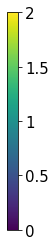

In [ ]:
# Clip arrays before plotting. Lower bound: 0 (no evidence either way), upper bound: 2 (decisive evidence).
bf_min, bf_max = 0, 2

for r in range(0, num_kinds):
    gs_kw = dict(hspace=-0.37, wspace=0, width_ratios=[1,1,1])
    fig, axs = plt.subplots(1,3, sharey=True, sharex=True, squeeze=True, gridspec_kw=gs_kw)

    (ax1, ax2, ax3) = axs

    ax1.imshow(np.transpose(log_bf_joint[r,:,:]), origin='lower', extent=[x_min, x_max, y_min, y_max], vmin = bf_min, vmax = bf_max)
    ax2.imshow(np.transpose(log_bf_nascent[r,:,:]), origin='lower', extent=[x_min, x_max, y_min, y_max], vmin = bf_min, vmax = bf_max)
    ax3.imshow(np.transpose(log_bf_mature[r,:,:]), origin='lower', extent=[x_min, x_max, y_min, y_max], vmin = bf_min, vmax = bf_max)

    plt.savefig('results/BF_grid_'+str(num_data_points[r])+'c.png', bbox_inches='tight')
    plt.savefig('results/BF_grid_'+str(num_data_points[r])+'c.pdf', bbox_inches='tight')
    plt.show()
    
    
#####

# Colorbar only
fig, ax = plt.subplots()
    
fake = np.array([[0,2]])
img = ax.imshow(fake)
ax.set_visible(False)
ax.axis('off')
cbar = fig.colorbar(img, ax=ax, ticks=[0, 0.5, 1, 1.5, 2], orientation="vertical")
cbar.ax.set_yticklabels(['0', 0.5, '1', 1.5, '2'])
cbar.ax.tick_params(labelsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

name = 'BF_cbar'
plt.savefig('results/'+name+'.png', bbox_inches='tight')
plt.savefig('results/'+name+'.svg', bbox_inches='tight')
plt.show()

----------------------------------------------------

## Panel B: Slice of a. to show distinguishability as a function of the gain ratio

We already have the results from a., so we only need to plot.

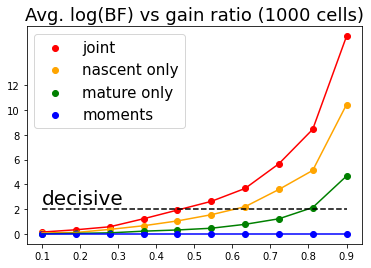

In [ ]:
which_kind = 2     # corresponds to using the 1000 cell row from the above
which_col = 4      # corresponds to taking a vertical slice through the middle  

plt.plot(y, log_bf_joint[which_kind, which_col,:], color='red')
plt.plot(y, log_bf_nascent[which_kind, which_col,:], color='orange')
plt.plot(y, log_bf_mature[which_kind, which_col,:], color='green')
plt.plot(y, np.zeros(num_y), color='blue')

plt.scatter(y, log_bf_joint[which_kind, which_col,:], label='joint', color='red')
plt.scatter(y, log_bf_nascent[which_kind, which_col,:], label='nascent only', color='orange')
plt.scatter(y, log_bf_mature[which_kind, which_col,:], label='mature only', color='green')
plt.scatter(y, np.zeros(num_y), label='moments', color='blue')

plt.plot(y, 2*np.ones(num_y), color='black', linestyle='--')

plt.yticks([0, 2, 4, 6, 8, 10, 12])
plt.title('Avg. log(BF) vs gain ratio (1000 cells)', fontsize=18)
plt.text(0.1, 2.4, "decisive", fontsize=20)
plt.legend(loc='upper left', fontsize=15)

plt.savefig('results/logBF_curve.png', bbox_inches='tight')
plt.savefig('results/logBF_curve.pdf', bbox_inches='tight')
plt.show()

---------------

# Panel C: Both models are distinguishable from null models

Reuse most of the same parameters from a. The only thing we'll change is that we'll only examine 1000 cells in this case.

In [ ]:
# Hyperparameters
num_data_points_null = 1000
num_trials = 100

# Output arrays
log_bf_CIR_vs_Poiss, log_bf_CIR_vs_NB = np.zeros(num_y), np.zeros(num_y)
log_bf_GOU_vs_Poiss, log_bf_GOU_vs_NB = np.zeros(num_y), np.zeros(num_y)


start_time = ti.time()
print("Computing log Bayes factors...")
for j in range(0, num_y):
    params = [beta, gamma, a[0,j], kappa[0,j], theta[0,j]]
    log_bf_CIR_vs_Poiss[j], log_bf_CIR_vs_NB[j], log_bf_GOU_vs_Poiss[j], log_bf_GOU_vs_NB[j] = (
        log_bayes_factor_avg_null(num_data_points_null, num_trials, mx, params) )
    
print("--- %s seconds ---" % (ti.time() - start_time))

Computing log Bayes factors...
--- 1.7851717472076416 seconds ---


Plot results.

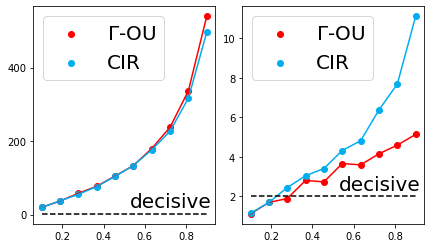

In [ ]:
gs_kw = dict(hspace=0, wspace=0.15, width_ratios=[1,1])
fig, axs = plt.subplots(1,2, figsize=(7,4), sharey=False, sharex=True, squeeze=True, gridspec_kw=gs_kw)
(ax1, ax2) = axs

# vs Poisson plot -------------
ax1.plot(y, log_bf_GOU_vs_Poiss, color='red')
ax1.plot(y, log_bf_CIR_vs_Poiss, color=(0., 174/255, 239/255))
ax1.scatter(y, log_bf_GOU_vs_Poiss, color='red', label=r'$\Gamma$-OU')
ax1.scatter(y, log_bf_CIR_vs_Poiss, color=(0., 174/255, 239/255), label='CIR')

ax1.plot(y, 2*np.ones(num_y), color='black', linestyle='--')

ax1.text(.53, 20.3, "decisive", fontsize=20)
ax1.legend(loc='upper left', fontsize=20)
ax1.set_yticks([0, 200, 400])


# vs NB plot --------------------------------
ax2.plot(y, log_bf_GOU_vs_NB, color='red')
ax2.plot(y, log_bf_CIR_vs_NB, color=(0., 174/255, 239/255))
ax2.scatter(y, log_bf_GOU_vs_NB, color='red', label=r'$\Gamma$-OU')
ax2.scatter(y, log_bf_CIR_vs_NB, color=(0., 174/255, 239/255), label='CIR')

ax2.plot(y, 2*np.ones(num_y), color='black', linestyle='--')

ax2.text(0.53, 2.3, "decisive", fontsize=20)
ax2.legend(loc='upper left', fontsize=20)


plt.savefig('results/logBF_trivials.png', bbox_inches='tight')
plt.savefig('results/logBF_trivials.pdf', bbox_inches='tight')
plt.show()

-----------------------------------

# Panel D: Maximally divergent parameter set

Elsewhere, we determined a parameter set that makes the $\Gamma$-OU and CIR models as 'different' as possible (where this difference is quantified via a KL divergence). In this panel, we plot the nascent and mature marginal distributions for both models for this parameter set.

In [ ]:
# Get maximally distinguishable parameter set
ind = np.unravel_index(np.argmax(log_bf_joint, axis=None), log_bf_joint.shape)
print(ind)
r, i, j = ind

params = [beta, gamma, a[i,j], kappa[i,j], theta[i,j]]
print("beta, gamma, a, kappa, theta")
print( params )


(3, 3, 9)
beta, gamma, a, kappa, theta
[1, 1.5, 0.8967126447482842, 1.4473684210526316, 8.070413802734553]


Compute joint probability distributions for $\Gamma$-OU and CIR models. Use these to obtain the nascent and mature marginals.

In [ ]:
mx = [70, 70]   # domain size

# Compute joint
pss_CIR, pss_GOU = get_CIR_2sp(mx, params), get_GOU_2sp(mx, params)

# Marginalize
pss_CIR_nascent, pss_CIR_mature = np.sum(pss_CIR, axis=1), np.sum(pss_CIR, axis=0)
pss_GOU_nascent, pss_GOU_mature = np.sum(pss_GOU, axis=1), np.sum(pss_GOU, axis=0)

Sample from $\Gamma$-OU and CIR distributions for this parameter set.

In [ ]:
np.random.seed(0)

num_data_points = 5000
d_GOU_N, d_GOU_M = sample_from_p(mx, num_data_points, pss_GOU.flatten())
d_CIR_N, d_CIR_M = sample_from_p(mx, num_data_points, pss_CIR.flatten())

Plot results.

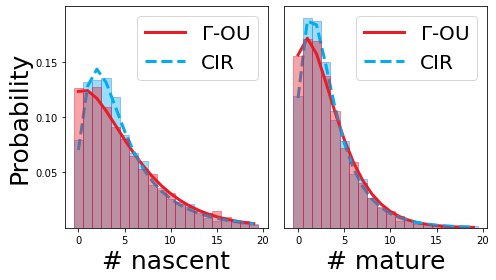

In [ ]:
gou_color = (237/255, 28/255, 36/255)
cir_color = (0, 174/255, 239/255)

fig1,ax1=plt.subplots(nrows=1,ncols=2,figsize=(7,4))

x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
xN_cut = 20   # where to cut off the nascent x axis
xM_cut = 20  # where to cut off the mature x axis

# Nascent marginal
ax1[0].hist(d_GOU_N,bins=x_N[:(xN_cut+1)]-0.5,density=True,color=gou_color,alpha=0.4,edgecolor='crimson', zorder=3)
ax1[0].hist(d_CIR_N,bins=x_N[:(xN_cut+1)]-0.5,density=True,color=cir_color,alpha=0.4,edgecolor='royalblue')
ax1[0].plot(x_N[:xN_cut], pss_GOU_nascent[:xN_cut],color=gou_color,linewidth=3,alpha=1,label=r'$\Gamma$-OU')
ax1[0].plot(x_N[:xN_cut], pss_CIR_nascent[:xN_cut],'--',color=cir_color,linewidth=3,alpha=1,label='CIR')
ax1[0].set_yticks([0.05, 0.1, 0.15])
ax1[0].set_ylim(0, 0.2)
ax1[0].set_ylabel('Probability',fontsize=25)
ax1[0].set_xlabel('# nascent',fontsize=25)
ax1[0].legend(fontsize=20)


# Mature marginal
ax1[1].hist(d_GOU_M,bins=x_M[:(xM_cut+1)]-0.5,density=True,color=gou_color,alpha=0.4,edgecolor='crimson',zorder=3)
ax1[1].hist(d_CIR_M,bins=x_M[:(xM_cut+1)]-0.5,density=True,color=cir_color,alpha=0.4,edgecolor='royalblue')
ax1[1].plot(x_M[:xM_cut], pss_GOU_mature[:xM_cut],color=gou_color,linewidth=3,alpha=1,label=r'$\Gamma$-OU')
ax1[1].plot(x_M[:xM_cut], pss_CIR_mature[:xM_cut],'--',color=cir_color,linewidth=3,alpha=1,label='CIR')
ax1[1].set_ylim(0, 0.2)
ax1[1].set_yticks([])
ax1[1].set_xlabel('# mature',fontsize=25)
ax1[1].legend(fontsize=20)


fig1.tight_layout()
plt.savefig('results/max_div.png', bbox_inches='tight')
plt.savefig('results/max_div.pdf', bbox_inches='tight')
plt.show()

----------------------------------------------

## Panel E: Parameter recovery

### Overdispersed/typical case

Define true parameter set.

In [ ]:
# Parameter set
K_avg = 10                   # Known
beta, gamma = 1, 1.7

x_true, y_true = 0.5, 0.7    # Unknown
a_true, kappa_true, theta_true = convert_xy_to_params(x_true, y_true, beta, gamma, K_avg)

params = [beta, gamma, a_true, kappa_true, theta_true]
const = [beta, gamma, K_avg]

Compute true probability distribution.

In [ ]:
mx = [40, 40]
Pss = get_GOU_2sp(mx, params)

Sample from distribution.

In [ ]:
np.random.seed(0)

num_data_points = 1000
d_N, d_M = sample_from_p(mx, num_data_points, Pss.flatten())
data = [d_N, d_M]

Plot samples and true distribution.

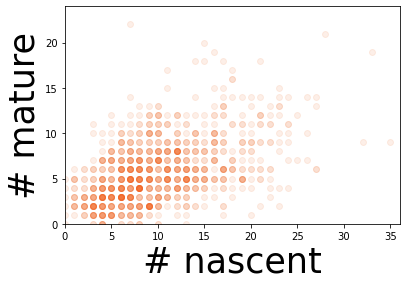

In [ ]:
w = 20

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(d_N, d_M, alpha=0.1, color=(242/255,101/255,34/255))

ax.set_xlim(0, 36)
ax.set_ylim(0, 24)
ax.set_xlabel('# nascent', fontsize=35)
ax.set_ylabel('# mature', fontsize=35)
plt.savefig('results/true_scatter_overdisp.png', bbox_inches='tight')
plt.savefig('results/true_scatter_overdisp.pdf', bbox_inches='tight')
plt.show()

Sequential sampling (4 chains in 1 job)
DEMetropolisZ: [y, x]


Sampling 4 chains for 1_000 tune and 12_000 draw iterations (4_000 + 48_000 draws total) took 1632 seconds.
The number of effective samples is smaller than 10% for some parameters.


--- 1633.7348682880402 seconds ---


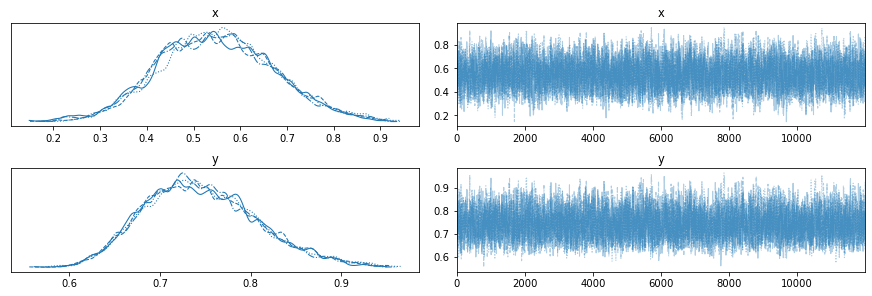

In [ ]:
string_ID = "overdispersed" 
trace, x_stats, y_stats = (
     get_parameter_posteriors(string_ID, const, mx, data, ll_func=ll_GOU2, draws_=12000, tune_=1000, chains_=4) )

Get histograms.

Plotting histograms in terms of (x,y)...


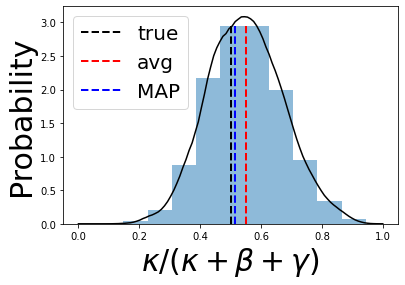

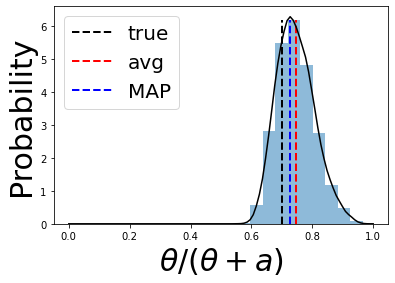

Plotting histograms in terms of (kappa, theta)...


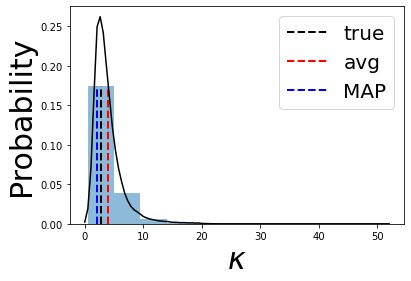

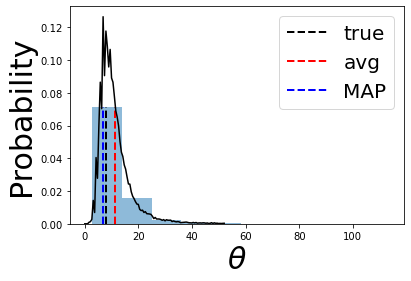

Plotting 2D heatmap in terms of (x, y)...


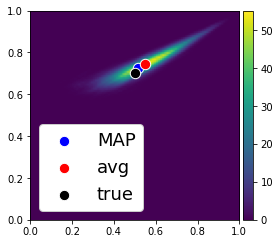

Plotting 2D heatmap in terms of (kappa, theta)...


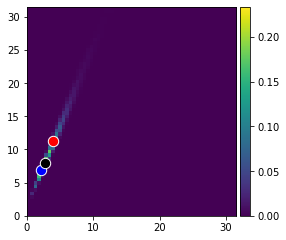

In [ ]:
loc = True
k_max = 52
th_max = 52
analyze_posteriors(string_ID, x_stats, y_stats, params, loc, k_max, th_max)

### Poisson-like/worst case

Define true parameter set.

In [ ]:
# Parameter set
K_avg = 10                   # Known
beta, gamma = 1, 1.7

x_true_bad, y_true_bad = 0.5, 0.05    # Unknown
a_true_bad, kappa_true_bad, theta_true_bad = convert_xy_to_params(x_true_bad, y_true_bad, beta, gamma, K_avg)

params_bad = [beta, gamma, a_true_bad, kappa_true_bad, theta_true_bad]
const_bad = [beta, gamma, K_avg]

Compute true probability distribution.

In [ ]:
mx = [40, 40]
Pss_bad = get_GOU_2sp(mx, params_bad)

Sample from distribution.

In [ ]:
np.random.seed(0)

num_data_points = 1000
d_N_bad, d_M_bad = sample_from_p(mx, num_data_points, Pss_bad.flatten())
data_bad = [d_N_bad, d_M_bad]

Plot samples and true distribution.

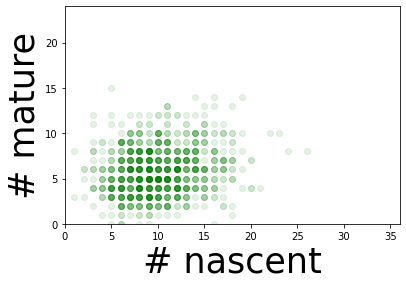

In [ ]:
w = 20

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(d_N_bad, d_M_bad, alpha=0.1, color='green')

ax.set_xlabel('# nascent', fontsize=35)
ax.set_ylabel('# mature', fontsize=35)
ax.set_xlim(0, 36)
ax.set_ylim(0, 24)
plt.savefig('results/true_scatter_poissonlike.png', bbox_inches='tight')
plt.savefig('results/true_scatter_poissonlike.pdf', bbox_inches='tight')
plt.show()

Sequential sampling (4 chains in 1 job)
DEMetropolisZ: [y, x]


<ipython-input-13-1e357f6a2c4d>:128: RuntimeWarning: divide by zero encountered in log
  lp = np.log(Pss)


Sampling 4 chains for 1_000 tune and 12_000 draw iterations (4_000 + 48_000 draws total) took 5491 seconds.
The number of effective samples is smaller than 10% for some parameters.


--- 5491.8386952877045 seconds ---


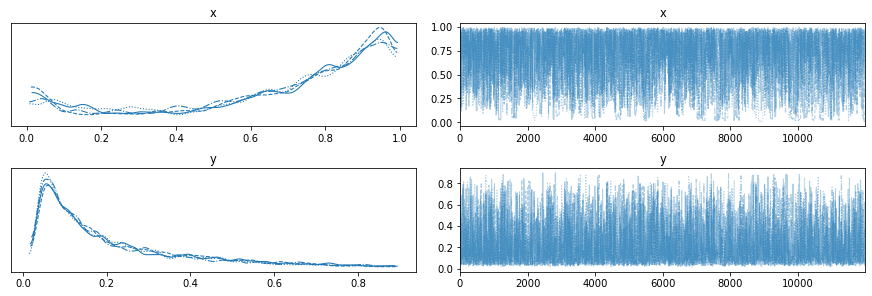

In [ ]:
string_ID_bad = "poissonlike" 
trace_bad, x_stats_bad, y_stats_bad = (
     get_parameter_posteriors(string_ID_bad, const_bad, mx, data_bad, ll_func=ll_GOU2, draws_=12000, tune_=1000, chains_=4) )

Get histograms.

Plotting histograms in terms of (x,y)...


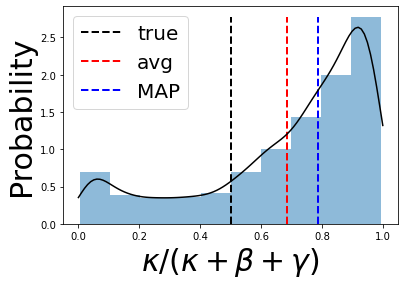

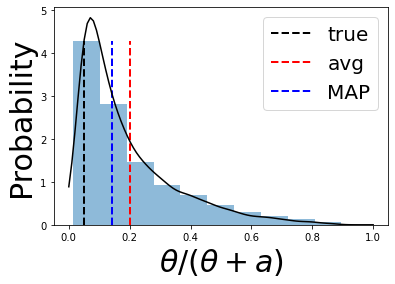

Plotting histograms in terms of (kappa, theta)...


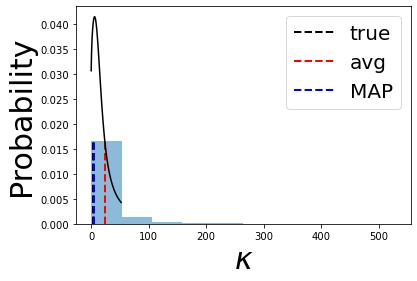

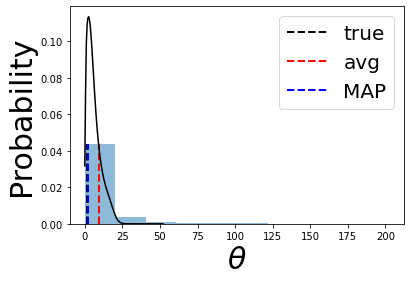

Plotting 2D heatmap in terms of (x, y)...


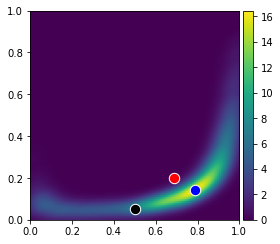

Plotting 2D heatmap in terms of (kappa, theta)...


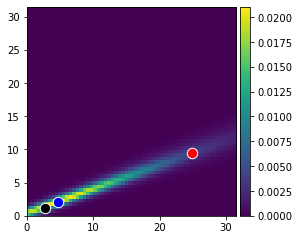

In [ ]:
loc_bad = False
k_max_bad = 52
th_max_bad = 52  # 25
analyze_posteriors(string_ID_bad, x_stats_bad, y_stats_bad, params_bad, loc_bad, k_max_bad, th_max_bad)

## Data saving

In [ ]:
np.save('bayes_runs/bad_x_stats.npy', x_stats_bad)
np.save('bayes_runs/bad_y_stats.npy', y_stats_bad)

np.save('bayes_runs/good_x_stats.npy', x_stats)
np.save('bayes_runs/good_y_stats.npy', y_stats)

In [ ]:
test = np.load('bayes_runs/good_x_stats.npy')

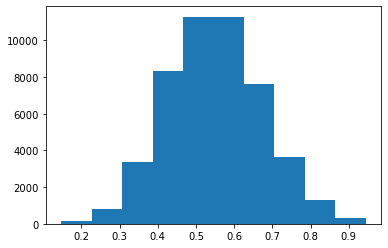

In [ ]:
plt.hist(test)
plt.show()